In [1]:
#В данном проекте попробуем расчитать цену закрытия свечи с использованием методов регресии, а также направление вверх/вниз с использованием методов классификации
#Будет использована библиотека scikit-learn

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import timedelta
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_absolute_percentage_error, mean_squared_log_error, explained_variance_score
import ta
import pandas as pd
import math

In [3]:
#Загружаем датасет
df = pd.read_csv("ex/BNB_5m_spot.csv", sep="|")
print(df)

        Unnamed: 0         timeopen BNB  opens BNB  high BNB  low BNB  \
0                0  2023-01-01 00:00:00      246.3     246.4    245.9   
1                1  2023-01-01 00:05:00      246.2     246.2    246.0   
2                2  2023-01-01 00:10:00      246.1     246.1    246.0   
3                3  2023-01-01 00:15:00      246.0     246.2    245.8   
4                4  2023-01-01 00:20:00      246.2     246.5    246.1   
...            ...                  ...        ...       ...      ...   
100690      100690  2024-05-17 09:30:00      576.7     577.6    576.4   
100691      100691  2024-05-17 09:35:00      577.4     577.8    577.1   
100692      100692  2024-05-17 09:40:00      577.2     577.3    576.7   
100693      100693  2024-05-17 09:45:00      576.7     577.2    576.6   
100694      100694  2024-05-17 09:50:00      576.9     577.0    576.4   

        closes BNB  volume BNB        timeclose BNB  volume_q BNB  kol BNB  \
0            246.2     440.108  2023-01-01 00

In [4]:
#Проверка на значения нулл
df.isnull().any()

Unnamed: 0       False
timeopen BNB     False
opens BNB        False
high BNB         False
low BNB          False
closes BNB       False
volume BNB       False
timeclose BNB    False
volume_q BNB     False
kol BNB          False
taker BNB        False
taker_q BNB      False
dtype: bool

In [5]:
#Нулл значений нет, предварительной очистки не понадобится
#Переименуем столбцы для удобства (уберем наименование BNB) и уберем лишние столбцы которые не несут полезную информацию
df = df.rename(columns={"taker_q BNB": "taker"
                        ,"timeopen BNB":"timeopen"
                        ,"opens BNB":"open"
                        ,"high BNB":"high"
                        ,"low BNB":"low"
                        ,"closes BNB":"close"
                        ,"volume BNB":"volume"
                        ,"timeclose BNB":"timeclose"
                        ,"volume_q BNB":"volume_q"
                        ,"kol BNB":"kol"
                        ,"taker BNB":"taker"
                        ,"taker_q BNB":"taker_q"})
df2 = df.drop(["Unnamed: 0","timeopen","timeclose"], axis=1)
df2

,open,high,low,close,volume,volume_q,kol,taker,taker_q
0,246.3,246.4,245.9,246.2,440.108,108352.6817,398,112.836,27774.6386
1,246.2,246.2,246.0,246.1,96.972,23864.2893,193,29.085,7159.3684
2,246.1,246.1,246.0,246.0,242.254,59614.6584,182,201.744,49649.1984
3,246.0,246.2,245.8,246.2,369.308,90839.1273,298,308.669,75929.1050
4,246.2,246.5,246.1,246.4,149.299,36778.8915,203,90.140,22204.3352
...,...,...,...,...,...,...,...,...,...
100690,576.7,577.6,576.4,577.3,1430.904,825786.8941,3768,985.478,568696.0126
100691,577.4,577.8,577.1,577.1,963.908,556597.8610,759,481.924,278302.3806
100692,577.2,577.3,576.7,576.8,377.282,217678.3757,468,107.554,62070.4330
100693,576.7,577.2,576.6,576.9,302.952,174786.0983,472,165.708,95605.0614


In [6]:
#Сделаем сдвиг на 1 период целевой переменной close т.к. нам необходимо расчитать цену закрытия на 1 шаг вперед
#Целевая переменная diff ее будем расчитывать
df2["diff"] = df2.shift(-1)["close"]
df2

,open,high,low,close,volume,volume_q,kol,taker,taker_q,diff
0,246.3,246.4,245.9,246.2,440.108,108352.6817,398,112.836,27774.6386,246.1
1,246.2,246.2,246.0,246.1,96.972,23864.2893,193,29.085,7159.3684,246.0
2,246.1,246.1,246.0,246.0,242.254,59614.6584,182,201.744,49649.1984,246.2
3,246.0,246.2,245.8,246.2,369.308,90839.1273,298,308.669,75929.1050,246.4
4,246.2,246.5,246.1,246.4,149.299,36778.8915,203,90.140,22204.3352,246.7
...,...,...,...,...,...,...,...,...,...,...
100690,576.7,577.6,576.4,577.3,1430.904,825786.8941,3768,985.478,568696.0126,577.1
100691,577.4,577.8,577.1,577.1,963.908,556597.8610,759,481.924,278302.3806,576.8
100692,577.2,577.3,576.7,576.8,377.282,217678.3757,468,107.554,62070.4330,576.9
100693,576.7,577.2,576.6,576.9,302.952,174786.0983,472,165.708,95605.0614,576.5


In [7]:
#Уберем последнюю строку т.к. целевая переменная нулл
df3 = df2[:-1]
df3

,open,high,low,close,volume,volume_q,kol,taker,taker_q,diff
0,246.3,246.4,245.9,246.2,440.108,108352.6817,398,112.836,27774.6386,246.1
1,246.2,246.2,246.0,246.1,96.972,23864.2893,193,29.085,7159.3684,246.0
2,246.1,246.1,246.0,246.0,242.254,59614.6584,182,201.744,49649.1984,246.2
3,246.0,246.2,245.8,246.2,369.308,90839.1273,298,308.669,75929.1050,246.4
4,246.2,246.5,246.1,246.4,149.299,36778.8915,203,90.140,22204.3352,246.7
...,...,...,...,...,...,...,...,...,...,...
100689,576.1,576.9,576.1,576.7,634.256,365731.3320,784,303.764,175166.1766,577.3
100690,576.7,577.6,576.4,577.3,1430.904,825786.8941,3768,985.478,568696.0126,577.1
100691,577.4,577.8,577.1,577.1,963.908,556597.8610,759,481.924,278302.3806,576.8
100692,577.2,577.3,576.7,576.8,377.282,217678.3757,468,107.554,62070.4330,576.9


In [8]:
#Добавим несколько новых расчетных признаков которые возможно помогут в более точном предсказании
#Новые признаки - технические индикаторы часто используемые в анализе рынка и на многих биржах предустановлены в платформу,
#например, скользящая средняя, экспоненциальная скользящая средняя, полосы боллинджера, стохастический индикатор и т.д.
#Более подробно формулы можно посмотреть в википедии, а функции можно посмотреть в модуле ta
closes = df3["close"].tolist()
upper, middle, lower, bb, abb, pr, bbpr = ta.BBANDS(closes, ma_period=20)
macd, macdsignal, macdhist = ta.MACD(closes, 12, 26, 9)
fast, slow = ta.STOCHRSI(closes, 20, 3, 3)
ema_20 = ta.EMA(closes,20)
mabb_20 = ta.SMA(bb,20)

In [9]:
df3

,open,high,low,close,volume,volume_q,kol,taker,taker_q,diff
0,246.3,246.4,245.9,246.2,440.108,108352.6817,398,112.836,27774.6386,246.1
1,246.2,246.2,246.0,246.1,96.972,23864.2893,193,29.085,7159.3684,246.0
2,246.1,246.1,246.0,246.0,242.254,59614.6584,182,201.744,49649.1984,246.2
3,246.0,246.2,245.8,246.2,369.308,90839.1273,298,308.669,75929.1050,246.4
4,246.2,246.5,246.1,246.4,149.299,36778.8915,203,90.140,22204.3352,246.7
...,...,...,...,...,...,...,...,...,...,...
100689,576.1,576.9,576.1,576.7,634.256,365731.3320,784,303.764,175166.1766,577.3
100690,576.7,577.6,576.4,577.3,1430.904,825786.8941,3768,985.478,568696.0126,577.1
100691,577.4,577.8,577.1,577.1,963.908,556597.8610,759,481.924,278302.3806,576.8
100692,577.2,577.3,576.7,576.8,377.282,217678.3757,468,107.554,62070.4330,576.9


In [10]:
#Добавляем в датасет новые признаки
df4 = df3.copy()
df4["upper"] = upper
df4["middle"] = middle
df4["lower"] = lower
df4["bb"] = bb
df4["abb"] = abb
df4["pr"] = pr
df4["bbpr"] = bbpr
df4["macd"] = macd
df4["macdsignal"] = macdsignal
df4["macdhist"] = macdhist
df4["fast"] = fast
df4["slow"] = slow
df4["ema_20"] = ema_20
df4["mabb_20"] = mabb_20
df4

,open,high,low,close,volume,volume_q,kol,taker,taker_q,diff,...,abb,pr,bbpr,macd,macdsignal,macdhist,fast,slow,ema_20,mabb_20
0,246.3,246.4,245.9,246.2,440.108,108352.6817,398,112.836,27774.6386,246.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,246.2,246.2,246.0,246.1,96.972,23864.2893,193,29.085,7159.3684,246.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,246.1,246.1,246.0,246.0,242.254,59614.6584,182,201.744,49649.1984,246.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,246.0,246.2,245.8,246.2,369.308,90839.1273,298,308.669,75929.1050,246.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,246.2,246.5,246.1,246.4,149.299,36778.8915,203,90.140,22204.3352,246.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100689,576.1,576.9,576.1,576.7,634.256,365731.3320,784,303.764,175166.1766,577.3,...,-4.313514,0.431351,3.882162,0.356213,0.434471,-0.078257,32.478562,30.126336,576.018716,6.492088
100690,576.7,577.6,576.4,577.3,1430.904,825786.8941,3768,985.478,568696.0126,577.1,...,-4.313514,0.431351,3.882162,0.420196,0.431616,-0.011419,39.947169,35.036753,576.140743,6.115619
100691,577.4,577.8,577.1,577.1,963.908,556597.8610,759,481.924,278302.3806,576.8,...,-3.926118,0.392612,3.533506,0.449583,0.435209,0.014373,44.573344,39.805048,576.232101,5.733946
100692,577.2,577.3,576.7,576.8,377.282,217678.3757,468,107.554,62070.4330,576.9,...,-3.686245,0.368624,3.317620,0.443551,0.436877,0.006673,42.117766,40.961407,576.286187,5.364739


In [11]:
#Появились значения нулл т.к. расчетные признаки считаются на основе предыдущих данных, и там где их нет, ставится нулл
df4.isnull().any()

open          False
high          False
low           False
close         False
volume        False
volume_q      False
kol           False
taker         False
taker_q       False
diff          False
upper          True
middle         True
lower          True
bb             True
abb            True
pr             True
bbpr           True
macd           True
macdsignal     True
macdhist       True
fast           True
slow           True
ema_20         True
mabb_20        True
dtype: bool

In [12]:
#Избавимся от строк где есть нулл
df_cleaned = df4.dropna()

In [13]:
#Проверим теперь не должно быть нуллов
df_cleaned.isnull().any()

open          False
high          False
low           False
close         False
volume        False
volume_q      False
kol           False
taker         False
taker_q       False
diff          False
upper         False
middle        False
lower         False
bb            False
abb           False
pr            False
bbpr          False
macd          False
macdsignal    False
macdhist      False
fast          False
slow          False
ema_20        False
mabb_20       False
dtype: bool

In [14]:
#Итоговый датасет перед обучением
df_cleaned = df_cleaned.reset_index()
df_cleaned

,index,open,high,low,close,volume,volume_q,kol,taker,taker_q,...,abb,pr,bbpr,macd,macdsignal,macdhist,fast,slow,ema_20,mabb_20
0,42,245.3,245.3,245.1,245.2,309.508,75898.4733,232,181.663,44554.4194,...,-0.834026,0.083403,0.750624,-0.170507,-0.165272,-0.005235,17.938054,24.148028,245.474397,0.163671
1,43,245.3,245.4,245.2,245.3,251.936,61791.7801,151,111.630,27384.5804,...,-0.800999,0.080100,0.720899,-0.163795,-0.164977,0.001182,25.840977,24.994502,245.457788,0.203721
2,44,245.2,245.3,245.2,245.2,110.998,27219.4747,135,27.651,6782.7903,...,-0.824621,0.082462,0.742159,-0.164647,-0.164911,0.000264,20.832151,22.913326,245.433237,0.244952
3,45,245.3,245.4,245.2,245.4,244.921,60078.8521,165,174.282,42752.4312,...,-0.813880,0.081388,0.732492,-0.147483,-0.161425,0.013942,42.456292,32.684809,245.430071,0.285646
4,46,245.3,245.4,245.2,245.4,458.546,112476.7505,242,201.928,49539.8693,...,-0.778460,0.077846,0.700614,-0.132356,-0.155611,0.023256,53.268363,42.976586,245.427207,0.324569
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100647,100689,576.1,576.9,576.1,576.7,634.256,365731.3320,784,303.764,175166.1766,...,-4.313514,0.431351,3.882162,0.356213,0.434471,-0.078257,32.478562,30.126336,576.018716,6.492088
100648,100690,576.7,577.6,576.4,577.3,1430.904,825786.8941,3768,985.478,568696.0126,...,-4.313514,0.431351,3.882162,0.420196,0.431616,-0.011419,39.947169,35.036753,576.140743,6.115619
100649,100691,577.4,577.8,577.1,577.1,963.908,556597.8610,759,481.924,278302.3806,...,-3.926118,0.392612,3.533506,0.449583,0.435209,0.014373,44.573344,39.805048,576.232101,5.733946
100650,100692,577.2,577.3,576.7,576.8,377.282,217678.3757,468,107.554,62070.4330,...,-3.686245,0.368624,3.317620,0.443551,0.436877,0.006673,42.117766,40.961407,576.286187,5.364739


In [15]:
#Предварительная обработка данных завершена,
#Приступаем к обучению, для начала будем решать задачу регресии, попробуем несколько алгоритмов.
#Напоминаю, целевая переменная diff, и сейчас разобьем датасет на трейн и тест с использованием sklearn
#Метрику для проверки будем использовать среднеквадратичное отклонение
from sklearn.model_selection import train_test_split
X = df_cleaned.drop("diff",axis = 1)
Y = df_cleaned["diff"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.15, random_state = 144)

Text(0.5, 1.0, 'Linear regression\n root_mean_squared_error 0.6870254203726858 degrees')

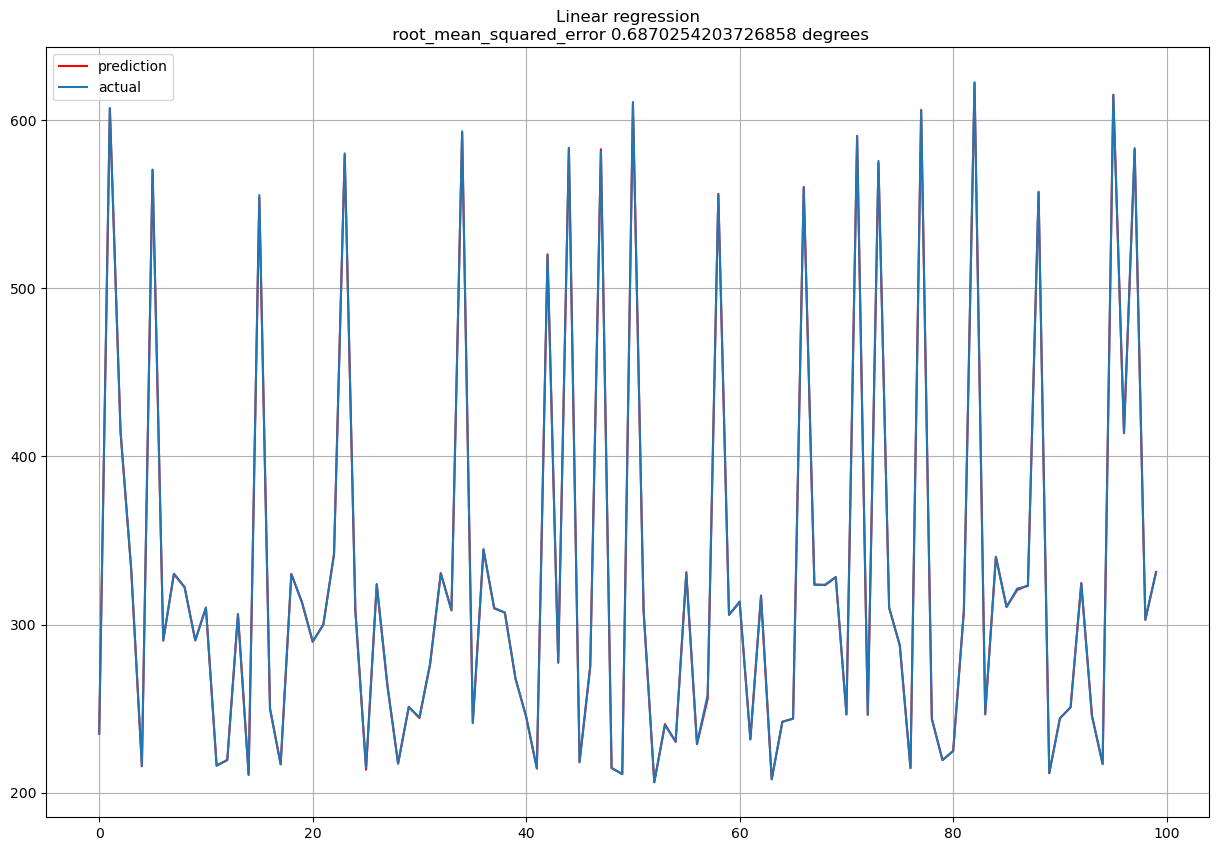

In [16]:
#Линейная регрессия
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, Y_train)

preds = lr.predict(X_test)

plt.figure(figsize=(15, 10))
plt.plot(preds[-100:], "r", label="prediction")
plt.plot(Y_test.values[-100:], label="actual")
plt.grid(True)
plt.legend(loc="best")
plt.title(f"Linear regression\n root_mean_squared_error {math.sqrt(mean_squared_error(preds, Y_test))} degrees")

In [17]:
#Для примера расчитаем ошибку если бы мы не предсказывали цену а просто брали бы текущую цену закрытия
#По хорошему должно быть значение меньше чем это, но это не так
math.sqrt(mean_squared_error(X_test["close"], Y_test))

0.6868236445920437

Text(0.5, 1.0, 'DecisionTreeRegressor\n root_mean_squared_error 1.0313421890054848 degrees')

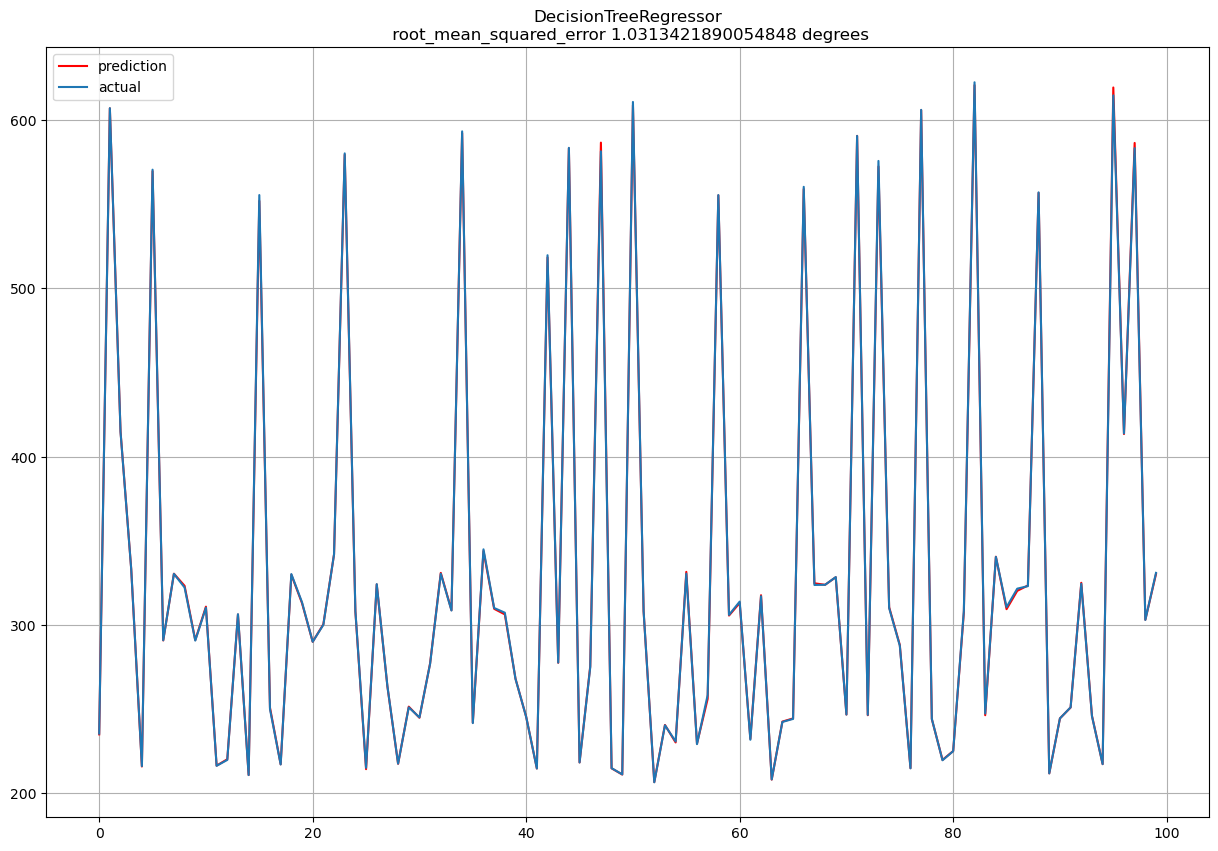

In [18]:
#Как видим график нам никакой полезной информации не дает т.к. дельта на фоне общего графика настолько мала, что ее не видно наглядно, будем ориентироваться только на метрику
# Деревья решений
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor()
dt.fit(X_train, Y_train)
preds = dt.predict(X_test)

plt.figure(figsize=(15, 10))
plt.plot(preds[-100:], "r", label="prediction")
plt.plot(Y_test[-100:].values, label="actual")
plt.grid(True)
plt.legend(loc="best")
plt.title(f"DecisionTreeRegressor\n root_mean_squared_error {math.sqrt(mean_squared_error(preds, Y_test))} degrees")

Text(0.5, 1.0, 'DecisionTreeRegressor\n root_mean_squared_error 0.7489657226662438 degrees')

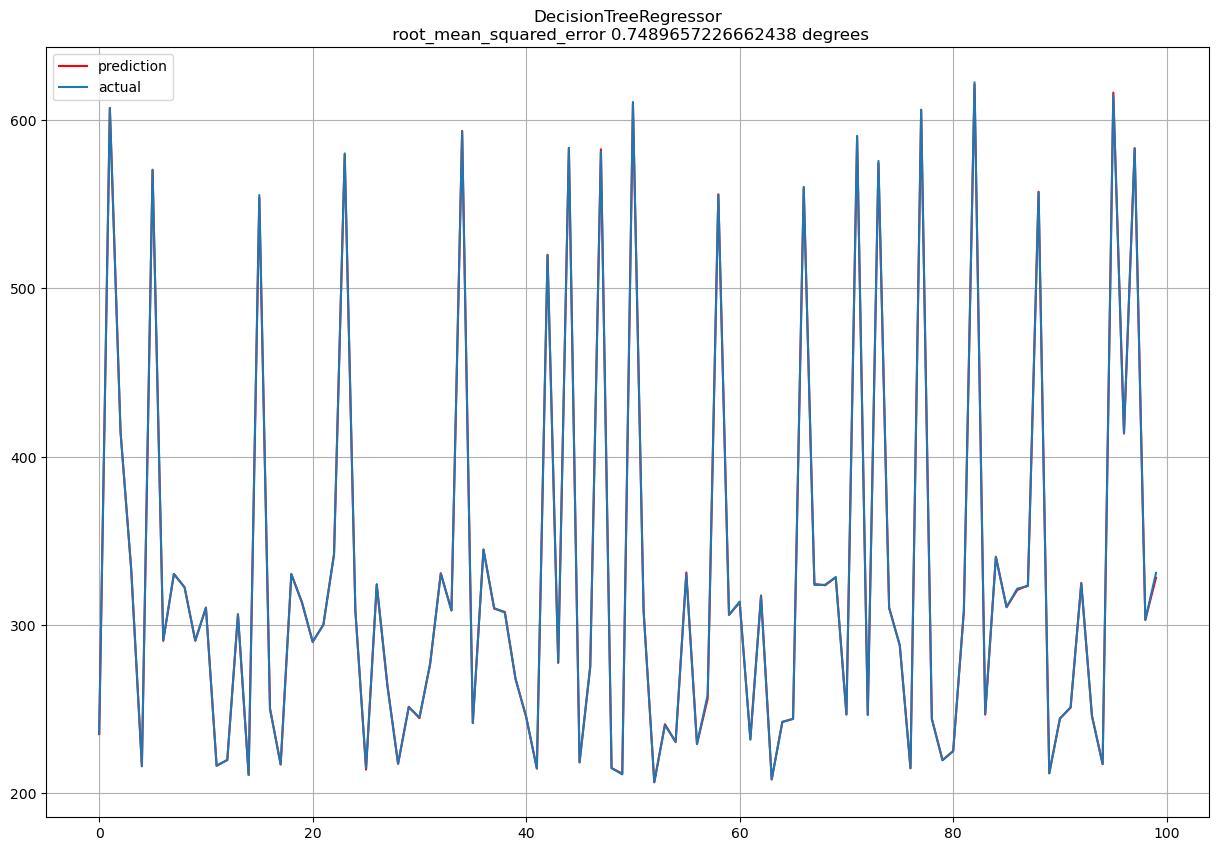

In [19]:
# Случайный лес
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
rf.fit(X_train, Y_train)
preds = rf.predict(X_test)

plt.figure(figsize=(15, 10))
plt.plot(preds[-100:], "r", label="prediction")
plt.plot(Y_test[-100:].values, label="actual")
plt.grid(True)
plt.legend(loc="best")
plt.title(f"DecisionTreeRegressor\n root_mean_squared_error {math.sqrt(mean_squared_error(preds, Y_test))} degrees")

Learning rate set to 0.220077
0:	learn: 88.6716261	total: 50.7ms	remaining: 15.2s
1:	learn: 69.6645669	total: 53.5ms	remaining: 7.96s
2:	learn: 54.8028863	total: 56ms	remaining: 5.54s
3:	learn: 43.1625605	total: 58.6ms	remaining: 4.34s
4:	learn: 33.9300310	total: 61.1ms	remaining: 3.6s
5:	learn: 26.8766571	total: 63.6ms	remaining: 3.12s
6:	learn: 21.1814753	total: 66.1ms	remaining: 2.77s
7:	learn: 16.7375270	total: 68.6ms	remaining: 2.5s
8:	learn: 13.3504057	total: 70.9ms	remaining: 2.29s
9:	learn: 10.6874443	total: 73.5ms	remaining: 2.13s
10:	learn: 8.6367220	total: 76ms	remaining: 2s
11:	learn: 7.0639314	total: 78.4ms	remaining: 1.88s
12:	learn: 5.8644225	total: 80.9ms	remaining: 1.78s
13:	learn: 4.9836786	total: 83.3ms	remaining: 1.7s
14:	learn: 4.3447371	total: 85.7ms	remaining: 1.63s
15:	learn: 3.8823552	total: 88.2ms	remaining: 1.56s
16:	learn: 3.5712301	total: 90.6ms	remaining: 1.51s
17:	learn: 3.3497495	total: 92.9ms	remaining: 1.46s
18:	learn: 3.1672870	total: 95.3ms	remaining

Text(0.5, 1.0, 'DecisionTreeRegressor\n root_mean_squared_error 1.191094100999154 degrees')

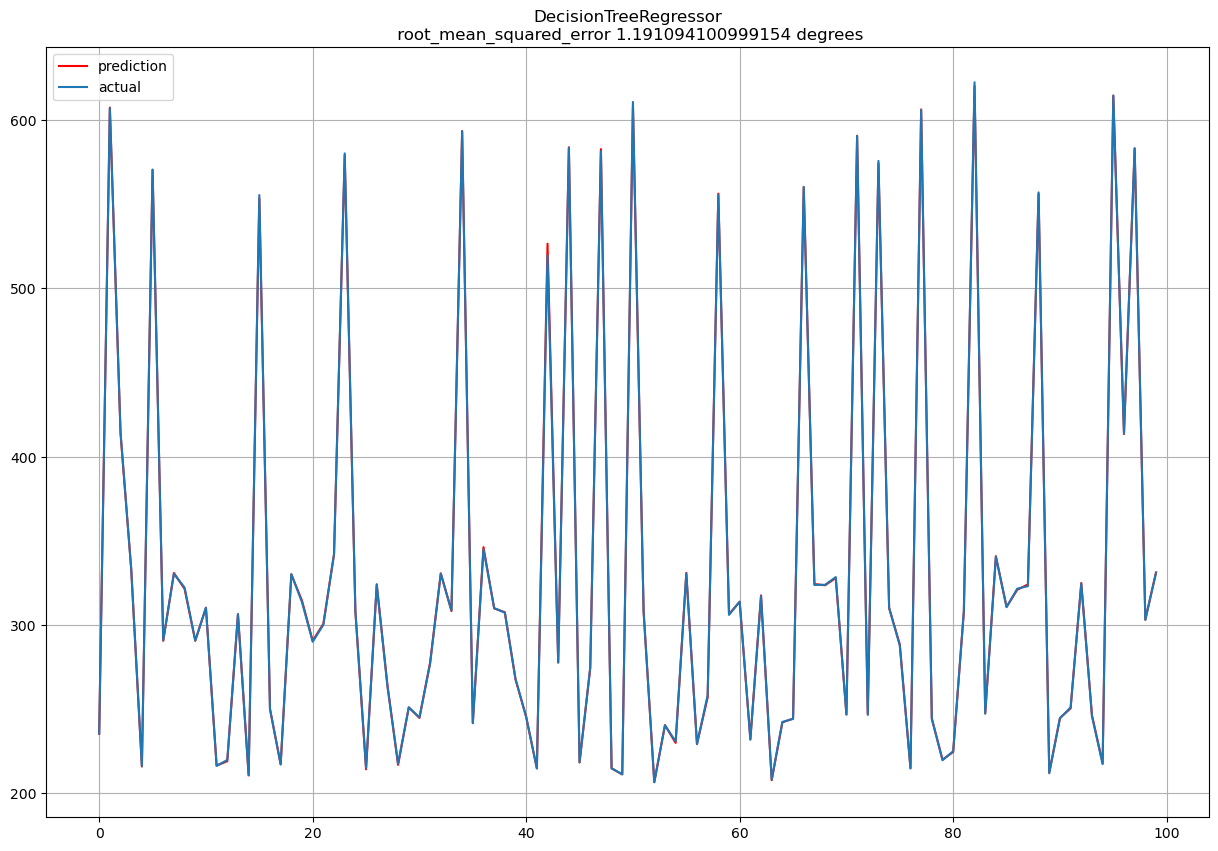

In [20]:
# Бустинг
from catboost import CatBoostRegressor
cb = CatBoostRegressor(n_estimators=300)
cb.fit(X_train, Y_train)
preds = cb.predict(X_test)

plt.figure(figsize=(15, 10))
plt.plot(preds[-100:], "r", label="prediction")
plt.plot(Y_test[-100:].values, label="actual")
plt.grid(True)
plt.legend(loc="best")
plt.title(f"DecisionTreeRegressor\n root_mean_squared_error {math.sqrt(mean_squared_error(preds, Y_test))} degrees")

In [21]:
#В общем так себе результаты получились, т.к. ни один из алгоритмов не обеспечил ошибку меньшую чем мы бы брали просто текущую цену закрытия
#Предлагаю перейти к задаче классификации
#Для этого необходимо создать целевую переменную со значениями up/down где up значит цена ушла вверх за последний период времени, а down соответственно вниз
df_cleaned2 = df_cleaned.copy()
df_cleaned2 = df_cleaned2.drop(["index"], axis = 1)
df_cleaned2["direction"] = df_cleaned2["diff"]-df_cleaned2["close"]
razn = df_cleaned2["direction"].tolist()
direction = [1 if x>=0 else 0 for x in razn]
df_cleaned2["direction"] = direction
df_cleaned3 = df_cleaned2.drop(["diff"], axis = 1)
df_cleaned3

,open,high,low,close,volume,volume_q,kol,taker,taker_q,upper,...,pr,bbpr,macd,macdsignal,macdhist,fast,slow,ema_20,mabb_20,direction
0,245.3,245.3,245.1,245.2,309.508,75898.4733,232,181.663,44554.4194,245.912013,...,0.083403,0.750624,-0.170507,-0.165272,-0.005235,17.938054,24.148028,245.474397,0.163671,1
1,245.3,245.4,245.2,245.3,251.936,61791.7801,151,111.630,27384.5804,245.870500,...,0.080100,0.720899,-0.163795,-0.164977,0.001182,25.840977,24.994502,245.457788,0.203721,0
2,245.2,245.3,245.2,245.2,110.998,27219.4747,135,27.651,6782.7903,245.862311,...,0.082462,0.742159,-0.164647,-0.164911,0.000264,20.832151,22.913326,245.433237,0.244952,1
3,245.3,245.4,245.2,245.4,244.921,60078.8521,165,174.282,42752.4312,245.846940,...,0.081388,0.732492,-0.147483,-0.161425,0.013942,42.456292,32.684809,245.430071,0.285646,1
4,245.3,245.4,245.2,245.4,458.546,112476.7505,242,201.928,49539.8693,245.814230,...,0.077846,0.700614,-0.132356,-0.155611,0.023256,53.268363,42.976586,245.427207,0.324569,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100647,576.1,576.9,576.1,576.7,634.256,365731.3320,784,303.764,175166.1766,578.566757,...,0.431351,3.882162,0.356213,0.434471,-0.078257,32.478562,30.126336,576.018716,6.492088,1
100648,576.7,577.6,576.4,577.3,1430.904,825786.8941,3768,985.478,568696.0126,578.566757,...,0.431351,3.882162,0.420196,0.431616,-0.011419,39.947169,35.036753,576.140743,6.115619,0
100649,577.4,577.8,577.1,577.1,963.908,556597.8610,759,481.924,278302.3806,578.303059,...,0.392612,3.533506,0.449583,0.435209,0.014373,44.573344,39.805048,576.232101,5.733946,0
100650,577.2,577.3,576.7,576.8,377.282,217678.3757,468,107.554,62070.4330,578.128122,...,0.368624,3.317620,0.443551,0.436877,0.006673,42.117766,40.961407,576.286187,5.364739,1


In [22]:
#Поскольку целевая переменная изменилась, необходимо заново разбить на трейн и тест
X2 = df_cleaned3.drop("direction",axis = 1)
Y2 = df_cleaned3["direction"]
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2, Y2, test_size = 0.15, random_state = 144)

In [23]:
#Логистическая регрессия
from sklearn.linear_model import LogisticRegression

logr = LogisticRegression()
logr.fit(X2_train,Y2_train)
pred = logr.predict(X2_test)

In [24]:
#При необходимости можно посмотреть коэф. влияния на целевую переменную
logr.coef_

array([[ 1.15087571e-04,  1.15005601e-04,  1.15069595e-04,
         1.14906355e-04,  6.22423456e-05, -1.57692845e-07,
         2.04784737e-05,  1.56064131e-05, -1.88814229e-07,
         1.15029935e-04,  1.15416888e-04,  1.15803840e-04,
        -7.73905283e-07,  7.73905283e-07, -7.73905283e-08,
        -6.96514755e-07, -1.56181856e-07, -1.09397903e-07,
        -4.67839530e-08,  2.69274004e-05,  3.01496634e-05,
         1.15376516e-04, -7.92700074e-07]])

In [25]:
#Выбрал метрику для классификации которая отражает больше информации
from sklearn.metrics import classification_report

In [26]:
print(classification_report(Y2_test,pred))

              precision    recall  f1-score   support

           0       0.49      0.01      0.02      6341
           1       0.58      0.99      0.73      8757

    accuracy                           0.58     15098
   macro avg       0.54      0.50      0.38     15098
weighted avg       0.54      0.58      0.43     15098



In [27]:
#Вывод: По результатам видим что accuracy 0.58 значит больше половины правильно предсказали, не сказать что результат хороший
#В дальнейшем нужно масштабировать признаки, попробовать кросс-валидацию и регуляризацию.